In [ ]:
!python -m spacy download fr_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 57.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import os
import re
from pathlib import Path
import spacy
from typing import List, Tuple
from tqdm import tqdm

nlp = spacy.load("fr_core_news_sm")
nlp.max_length = 3_000_000 # Increased max_length

def charger_corpus(dossier: str) -> List[Tuple[str, str]]:
    corpus = []
    for fichier in sorted(Path(dossier).glob("*.txt")):
        with open(fichier, "r", encoding="utf-8") as f:
            contenu = f.read()
            corpus.append((fichier.name, contenu))
    return corpus

def nettoyer_texte(
    texte: str,
    minuscule: bool = True,
    enlever_pontuation: bool = False,
    enlever_numeros: bool = True,
    enlever_espaces_multiples: bool = True
) -> str:
    if minuscule:
        texte = texte.lower()
    if enlever_pontuation:
        texte = re.sub(r"[^\w\s]", " ", texte)
    if enlever_numeros:
        texte = re.sub(r"\d+", "", texte)
    if enlever_espaces_multiples:
        texte = re.sub(r"\s+", " ", texte).strip()
    return texte

def tokenizer_spacy(texte: str) -> Tuple[List[str], List[str]]:
    doc = nlp(texte)
    mots = [token.text for token in doc if not token.is_space and not token.is_punct]
    phrases = [sent.text.strip() for sent in doc.sents]
    return mots, phrases

def traiter_corpus(dossier: str) -> Tuple[List[List[str]], List[List[str]], List[str]]:
    corpus = charger_corpus(dossier)
    token_mots_all = []
    token_phrase_all = []
    noms_fichiers = []

    for nom_fichier, contenu in tqdm(corpus, desc="Traitement du corpus"):
        texte_nettoye = nettoyer_texte(contenu)
        mots, phrases = tokenizer_spacy(texte_nettoye)
        token_mots_all.append(mots)
        token_phrase_all.append(phrases)
        noms_fichiers.append(nom_fichier)

    return token_mots_all, token_phrase_all, noms_fichiers

def sauvegarder_tokens(token_mots, token_phrase, noms_fichiers, dossier_sortie):
    os.makedirs(dossier_sortie, exist_ok=True)

    with open(os.path.join(dossier_sortie, "token_mots.txt"), "w", encoding="utf-8") as f_mots: # Changed path
        for tokens in token_mots:
            f_mots.write(" ".join(tokens) + "\n")

    with open(os.path.join(dossier_sortie, "token_phrase.txt"), "w", encoding="utf-8") as f_phrases: # Changed path
        for phrases in token_phrase:
            f_phrases.write(" | ".join(phrases) + "\n")

    with open(os.path.join(dossier_sortie, "token_mots_avec_noms.txt"), "w", encoding="utf-8") as f_mots_noms:
        for nom, tokens in zip(noms_fichiers, token_mots):
            f_mots_noms.write(f"=== {nom} ===\n{' '.join(tokens)}\n\n")

    with open(os.path.join(dossier_sortie, "token_phrases_avec_noms.txt"), "w", encoding="utf-8") as f_phrases_noms:
        for nom, phrases in zip(noms_fichiers, token_phrase):
            f_phrases_noms.write(f"=== {nom} ===\n{' | '.join(phrases)}\n\n")

def statistiques_corpus(token_mots, token_phrase):
    nb_textes = len(token_mots)
    total_mots = sum(len(doc) for doc in token_mots)
    total_phrases = sum(len(doc) for doc in token_phrase)
    moyenne_mots = total_mots / nb_textes if nb_textes else 0
    moyenne_phrases = total_phrases / nb_textes if nb_textes else 0

    print("Statistiques du corpus :")
    print(f"- Nombre de textes         : {nb_textes}")
    print(f"- Nombre total de mots     : {total_mots}")
    print(f"- Moyenne de mots/texte    : {moyenne_mots:.2f}")
    print(f"- Nombre total de phrases  : {total_phrases}")
    print(f"- Moyenne de phrases/texte : {moyenne_phrases:.2f}")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
dossier_corpus = "/content/drive/MyDrive/Colab Notebooks/Elex/chunks"
dossier_sortie = "/content/corpus_analyse_output" # Changed to a directory path

token_mots, token_phrase, noms = traiter_corpus(dossier_corpus)
sauvegarder_tokens(token_mots, token_phrase, noms, dossier_sortie)
statistiques_corpus(token_mots, token_phrase)

Traitement du corpus: 100%|██████████| 50/50 [56:40<00:00, 68.01s/it]


Statistiques du corpus :
- Nombre de textes         : 50
- Nombre total de mots     : 15664427
- Moyenne de mots/texte    : 313288.54
- Nombre total de phrases  : 1069325
- Moyenne de phrases/texte : 21386.50


In [ ]:
import math
import itertools
import pandas as pd
from collections import Counter
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# === TF-IDF ===
def extraire_tfidf(corpus_lignes, ngram_range=(1, 3), top_n=100):
    vectorizer = TfidfVectorizer(ngram_range=ngram_range)
    X = vectorizer.fit_transform(corpus_lignes)
    scores = zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1)
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)[:top_n]
    df = pd.DataFrame(sorted_scores, columns=["ngram", "score"])
    df["méthode"] = "TF-IDF"
    return df

# === PMI ===
def calculer_pmi(corpus_tokens, ngram=2, min_freq=3, top_n=100):
    ngrams = list(itertools.chain.from_iterable([
        list(zip(*[tokens[i:] for i in range(ngram)]))
        for tokens in corpus_tokens if len(tokens) >= ngram
    ]))
    ngram_freq = Counter(ngrams)
    ngram_freq = {k: v for k, v in ngram_freq.items() if v >= min_freq}
    word_freq = Counter(itertools.chain.from_iterable(corpus_tokens))
    total_words = sum(word_freq.values())
    total_ngrams = sum(ngram_freq.values())

    def pmi(ng):
        prob_ngram = ngram_freq[ng] / total_ngrams
        prob_parts = np.prod([word_freq[w] / total_words for w in ng])
        return math.log(prob_ngram / prob_parts + 1e-12, 2)

    pmi_scores = [(ng, pmi(ng)) for ng in ngram_freq]
    sorted_pmi = sorted(pmi_scores, key=lambda x: x[1], reverse=True)[:top_n]
    df = pd.DataFrame([( " ".join(ng), score ) for ng, score in sorted_pmi], columns=["ngram", "score"])
    df["méthode"] = f"PMI-{ngram}gram"
    return df

# === RAKE ===
def extraire_rake(corpus_lignes, stopwords_fr, top_n=100):
    from rake_nltk import Rake
    rake = Rake(language='french', stopwords=stopwords_fr)
    rake.extract_keywords_from_text("\n".join(corpus_lignes))
    keywords_scores = rake.get_ranked_phrases_with_scores()[:top_n]
    df = pd.DataFrame(keywords_scores, columns=["score", "ngram"])
    df["méthode"] = "RAKE"
    return df[["ngram", "score", "méthode"]]


In [ ]:
%pip install rake_nltk

In [ ]:
import os
import pandas as pd
import nltk
nltk.download('stopwords')  # 下载 RAKE 所依赖的 nltk 停用词列表

from pipeline_extraction import extraire_tfidf, calculer_pmi, extraire_rake

# === 1. 读取语料 ===

# 读取 token_phrase.txt（按行处理）
with open("/content/token_mots.txt", "r", encoding="utf-8") as f:
    corpus_lignes = [line.strip() for line in f if line.strip()]

# 读取 token_mots.txt（每行空格分词）
with open("/content/token_mots.txt", "r", encoding="utf-8") as f:
    corpus_tokens = [line.strip().split() for line in f if line.strip()]

# === 2. TF-IDF 提取 ===
df_tfidf = extraire_tfidf(corpus_lignes, ngram_range=(1, 3), top_n=100)

# === 3. PMI 提取 ===
df_pmi = calculer_pmi(corpus_tokens, ngram=2, min_freq=3, top_n=100)

# === 4. RAKE 提取 ===
# 注意：我们这里禁用默认的 stopwords，否则像 "donner un coup de main" 会被误删
stopwords_fr = set()  # 也可以用：{".", ",", ";", "!", "?"}
df_rake = extraire_rake(corpus_lignes, stopwords_fr, top_n=100)

# === 5. 合并所有结果并保存 ===
df_all = pd.concat([df_tfidf, df_pmi, df_rake], ignore_index=True)
df_all.to_csv("ulps.csv", index=False)
print("提取完成，结果保存在 ulps.csv")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


提取完成，结果保存在 ulps.csv


# **Étape suivante : extraction TF-IDF, PMI, RAKE**

In [ ]:
#1. Extraction TF-IDF


from sklearn.feature_extraction.text import TfidfVectorizer

def extraire_tfidf(token_mots, n_min=1, n_max=3, top_k=100):
    docs = [" ".join(mots) for mots in token_mots]
    vectorizer = TfidfVectorizer(ngram_range=(n_min, n_max), max_features=top_k)
    X = vectorizer.fit_transform(docs)
    scores = X.sum(axis=0).A1
    ngrams = vectorizer.get_feature_names_out()
    return [(ng, sc, "TF-IDF") for ng, sc in zip(ngrams, scores)]


In [ ]:
#2. Extraction PMI (simplifiée)

from collections import Counter
from math import log2

def extraire_pmi(token_mots, min_freq=3):
    unigram_freq = Counter()
    bigram_freq = Counter()

    for mots in token_mots:
        unigram_freq.update(mots)
        bigram_freq.update(zip(mots, mots[1:]))

    total_unigrams = sum(unigram_freq.values())
    total_bigrams = sum(bigram_freq.values())

    results = []
    for (w1, w2), bigram_count in bigram_freq.items():
        if bigram_count >= min_freq:
            p_xy = bigram_count / total_bigrams
            p_x = unigram_freq[w1] / total_unigrams
            p_y = unigram_freq[w2] / total_unigrams
            pmi = log2(p_xy / (p_x * p_y))
            results.append((f"{w1} {w2}", pmi, "PMI"))
    return results




In [ ]:
#3. Extraction RAKE

from rake_nltk import Rake

def extraire_rake(texts, n_min=1, n_max=3):
    rake = Rake(min_length=n_min, max_length=n_max)
    rake.extract_keywords_from_text("\n".join(texts))
    return [(phrase, score, "RAKE") for phrase, score in rake.get_ranked_phrases_with_scores()]


In [ ]:
#Fusion via RRF

def fusion_rrf(listes, k=60):
    from collections import defaultdict
    scores = defaultdict(float)
    méthode_map = defaultdict(set)

    for lst in listes:
        for rank, (ngram, _, méthode) in enumerate(sorted(lst, key=lambda x: -x[1])):
            rrf_score = 1 / (k + rank + 1)
            scores[ngram] += rrf_score
            méthode_map[ngram].add(méthode)

    results = [(ngram, score, ",".join(sorted(méthode_map[ngram]))) for ngram, score in scores.items()]
    return sorted(results, key=lambda x: -x[1])


In [ ]:
#Enregistrement

import pandas as pd

def enregistrer_ulps(resultats, chemin="ulps.csv"):
    df = pd.DataFrame(resultats, columns=["ngram", "rrf", "méthode"])
    df["est_idiome"] = False  # pour annotation manuelle
    df["thème"] = "inconnu"
    df.to_csv(chemin, index=False)


In [1]:
!pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 50.7 MB/s eta 0:00:00


In [ ]:
#安装 streamlit 和 pyngrok

!pip install streamlit pyngrok


In [ ]:
# 第二步：创建你的 Streamlit 应用文件（interface_ulps.py）

with open("interface_ulps.py", "w", encoding="utf-8") as f:
    f.write("""
import streamlit as st
import pandas as pd

st.title("Résultats TF-IDF, PMI et RAKE")

df = pd.read_csv("ulps.csv")

filtre = st.selectbox("Filtrer par méthode :", ["Tous"] + sorted(df["methode"].unique()))
if filtre != "Tous":
    df = df[df["methode"] == filtre]

st.dataframe(df)
""")


In [ ]:
#后台运行 Streamlit

!streamlit run interface_ulps.py &>/content/log.txt &


# **这里在VScode里面可以有**

In [ ]:
#第四步：启动 ngrok 隧道并显示访问链接

from pyngrok import ngrok
public_url = ngrok.connect(port=8501)
print(f" Cliquez ici pour accéder à l'application Streamlit : {public_url}")


ERROR:pyngrok.process.ngrok:t=2025-07-20T08:36:06+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-07-20T08:36:06+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-07-20T08:36:06+0000 lvl=eror msg="terminating with error" obj=app err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your aut

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.

#Exemple de script pipeline_extraction.py[texte du lien](https:// [texte du lien](https://))

根据Louis的改过


In [ ]:
import pandas as pd
import re
from collections import Counter
from pathlib import Path

def charger_idiomes(path):
    """Charger la liste d'idiomes"""
    with open(path, encoding="utf-8") as f:
        idiomes = [ligne.strip().lower() for ligne in f if ligne.strip()]
    return idiomes

def charger_corpus(path):
    """Charger le corpus tokenisé ligne par ligne"""
    with open(path, encoding="utf-8") as f:
        lignes = [ligne.strip().lower() for ligne in f if ligne.strip()]
    return lignes

def détecter_idiomes(corpus_lignes, liste_idiomes):
    """Cherche les idiomes exacts dans chaque ligne du corpus"""
    compteur = Counter()
    for ligne in corpus_lignes:
        for idiome in liste_idiomes:
            if idiome in ligne:
                compteur[idiome] += 1
    return compteur

def exporter_resultats(compteur_idiomes, fichier_csv="idiomes_detectes.csv"):
    df = pd.DataFrame(compteur_idiomes.items(), columns=["idiome", "fréquence"])
    df = df.sort_values(by="fréquence", ascending=False)
    df.to_csv(fichier_csv, index=False, encoding="utf-8")
    return df


In [ ]:
#Appel du pipeline :

idiomes = charger_idiomes("idiomscopie2.txt")
corpus = charger_corpus("token_mots.txt")
resultats = détecter_idiomes(corpus, idiomes)
df = exporter_resultats(resultats)
print(df.head())


           idiome  fréquence
0  bouc émissaire          9
1        être rat          1
2  brebis galeuse          1


In [ ]:
#Étape 2 — Créer une interface Streamlit d’annotation
#Exemple app_streamlit.py



import streamlit as st
import pandas as pd

st.title("Exploration des idiomes détectés")

@st.cache_data
def charger_donnees():
    return pd.read_csv("idiomes_detectes.csv")

df = charger_donnees()

# Ajout de filtres interactifs
min_freq = st.slider("Filtrer par fréquence minimale", min_value=1, max_value=100, value=5)
filtré = df[df["fréquence"] >= min_freq]

# Ajout d'une colonne d'annotation
filtré["annotation"] = ""

# Affichage du tableau
st.dataframe(filtré)

# Export si souhaité
if st.button("Exporter les annotations"):
    filtré.to_csv("idiomes_annotes.csv", index=False, encoding="utf-8")
    st.success(" Fichier idiomes_annotes.csv exporté")


2025-07-20 08:47:43.486 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-20 08:47:43.488 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-20 08:47:43.489 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-20 08:47:43.489 No runtime found, using MemoryCacheStorageManager
2025-07-20 08:47:43.491 No runtime found, using MemoryCacheStorageManager
2025-07-20 08:47:43.507 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-20 08:47:43.508 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-20 08:47:43.510 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-20 08:47:43.512 Thread 'MainThread': missing ScriptRunContext! This warning can be ignor

# **以下是完整函数，你只需运行（推荐保存为 relations_extraction.py）：donner un coup de main -> main -> aide**

In [ ]:
import spacy
import re

# 载入模型（建议：fr_core_news_md）
nlp = spacy.load("fr_core_news_sm")

# 载入资源文件
def charger_liste(chemin):
    with open(chemin, encoding="utf-8") as f:
        return set([l.strip().lower() for l in f if l.strip()])

idiomes = charger_liste("/content/idiomscopie2.txt")
mots_corps = charger_liste("/content/mots_corps.txt")
mots_animaux = charger_liste("/content/mots_animaux.txt")
mots_cles = mots_corps.union(mots_animaux)

# Nettoyer une phrase
def nettoyer(texte):
    texte = re.sub(r"\s+", " ", texte)
    return texte.strip().lower()

# 主函数：提取关系
def extraire_relations_depuis_phrases(chemin_token_phrase):
    triplets = []
    with open(chemin_token_phrase, encoding="utf-8") as f:
        phrases = [nettoyer(l) for l in f if l.strip()]

    for phrase in phrases:
        doc = nlp(phrase)
        phrase_tokens = phrase.split()

        # 查找句中是否含有成语 + 关键词
        idiomes_trouvés = [i for i in idiomes if i in phrase]
        mots_trouvés = [m for m in mots_cles if m in phrase]

        if not idiomes_trouvés or not mots_trouvés:
            continue  # 若都不在，就跳过

        for idiome in idiomes_trouvés:
            for mot in mots_trouvés:
                # 使用 spaCy 解析这句话
                for token in doc:
                    if token.text in idiome.split():
                        if token.dep_ in ["nsubj", "nsubj:pass"]:  # 是主语
                            # 查找相关的动词宾语等
                            for tok in doc:
                                if tok.head == token and tok.dep_ in ["obj", "dobj", "obl", "attr"]:
                                    relation = tok.text
                                    triplets.append((idiome, mot, relation))
                                    break
                            else:
                                # 默认关系（没有直接宾语）
                                triplets.append((idiome, mot, "lié à"))
                        else:
                            # 不做主语也保留弱关系
                            triplets.append((idiome, mot, "lié à"))
                        break  # 只保留一个主关系
    return triplets

# 保存结果 CSV
import pandas as pd

def sauvegarder_triplets(triplets, fichier_csv):
    df = pd.DataFrame(triplets, columns=["idiome", "mot_clé", "relation"])
    df["poids"] = 1
    df_groupé = df.groupby(["idiome", "mot_clé", "relation"]).agg({"poids": "sum"}).reset_index()
    df_groupé.to_csv(fichier_csv, index=False, encoding="utf-8")
    print(f"Triplets enregistrés dans : {fichier_csv}")

In [ ]:
!pip install tqdm


In [ ]:
import time
from tqdm import tqdm

# 开始计时
debut = time.time()
print("Traitement du corpus...")

# 读取语料库文件并提取关系
# Call the function with the file path, not each line
triplets = extraire_relations_depuis_phrases("/content/token_phrase.txt")

# 结束提取计时
milieu = time.time()
print(f"\nExtraction terminée en {milieu - debut:.2f} secondes.")

print("Sauvegarde du graphe...")
sauvegarder_triplets(triplets, "graph_edges.csv")

# 结束保存计时
fin = time.time()
print(f" Sauvegarde terminée en {fin - milieu:.2f} secondes.")
print(f"⏱Durée totale : {fin - debut:.2f} secondes.")

Traitement du corpus...

Extraction terminée en 6833.37 secondes.
Sauvegarde du graphe...
Triplets enregistrés dans : graph_edges.csv
 Sauvegarde terminée en 0.05 secondes.
⏱Durée totale : 6833.43 secondes.


In [ ]:
import pandas as pd

# 加载 idiome -> mot 的三元组图谱
df = pd.read_csv("graph_edges.csv", names=["idiome", "mot", "relation", "poids"])

# 你的语义映射表
semantic_map = {
    "bras": "accueil",
    "chair": "corps",
    "cœur": "mémoire",
    "visage": "identité",
    "main": "aide",
    "œil": "perception",
    "yeux": "confiance",
    "pied": "stabilité",
    "talon": "faiblesse",
    "tête": "intelligence",
    "cochon": "obstination",
    "chien": "malheur",
    "poule": "peur",
    "fourmi": "travail",
    "loup": "appétit",
    "bouc": "culpabilité",
    "brebis": "déviance",
    "oiseau": "rareté",
    "ailes": "autonomie",
    "poisson": "inadéquation",
    "rat": "ruse"
}

# 构建三元组链 idiome → mot → sémantique
triplets_semantiques = []
for _, row in df.iterrows():
    idiome = row["idiome"]
    mot = row["mot"]
    if mot in semantic_map:
        sem = semantic_map[mot]
        triplets_semantiques.append((idiome, mot, sem))

# 显示前几项
for t in triplets_semantiques[:10]:
    print(f"{t[0]} → {t[1]} → {t[2]}")

# 可选：导出
pd.DataFrame(triplets_semantiques, columns=["idiome", "mot", "sémantique"]).to_csv("triplets_semantiques.csv", index=False)


avoir la main → chair → corps
avoir la main → pied → stabilité
brebis galeuse → chien → malheur
brebis galeuse → loup → appétit
comme un poisson hors de l'eau → poisson → inadéquation
connaître par cœur → cœur → mémoire
de pied ferme → pied → stabilité
en avoir le cœur net → cœur → mémoire
en chair et en os → chair → corps
les yeux fermés → chien → malheur


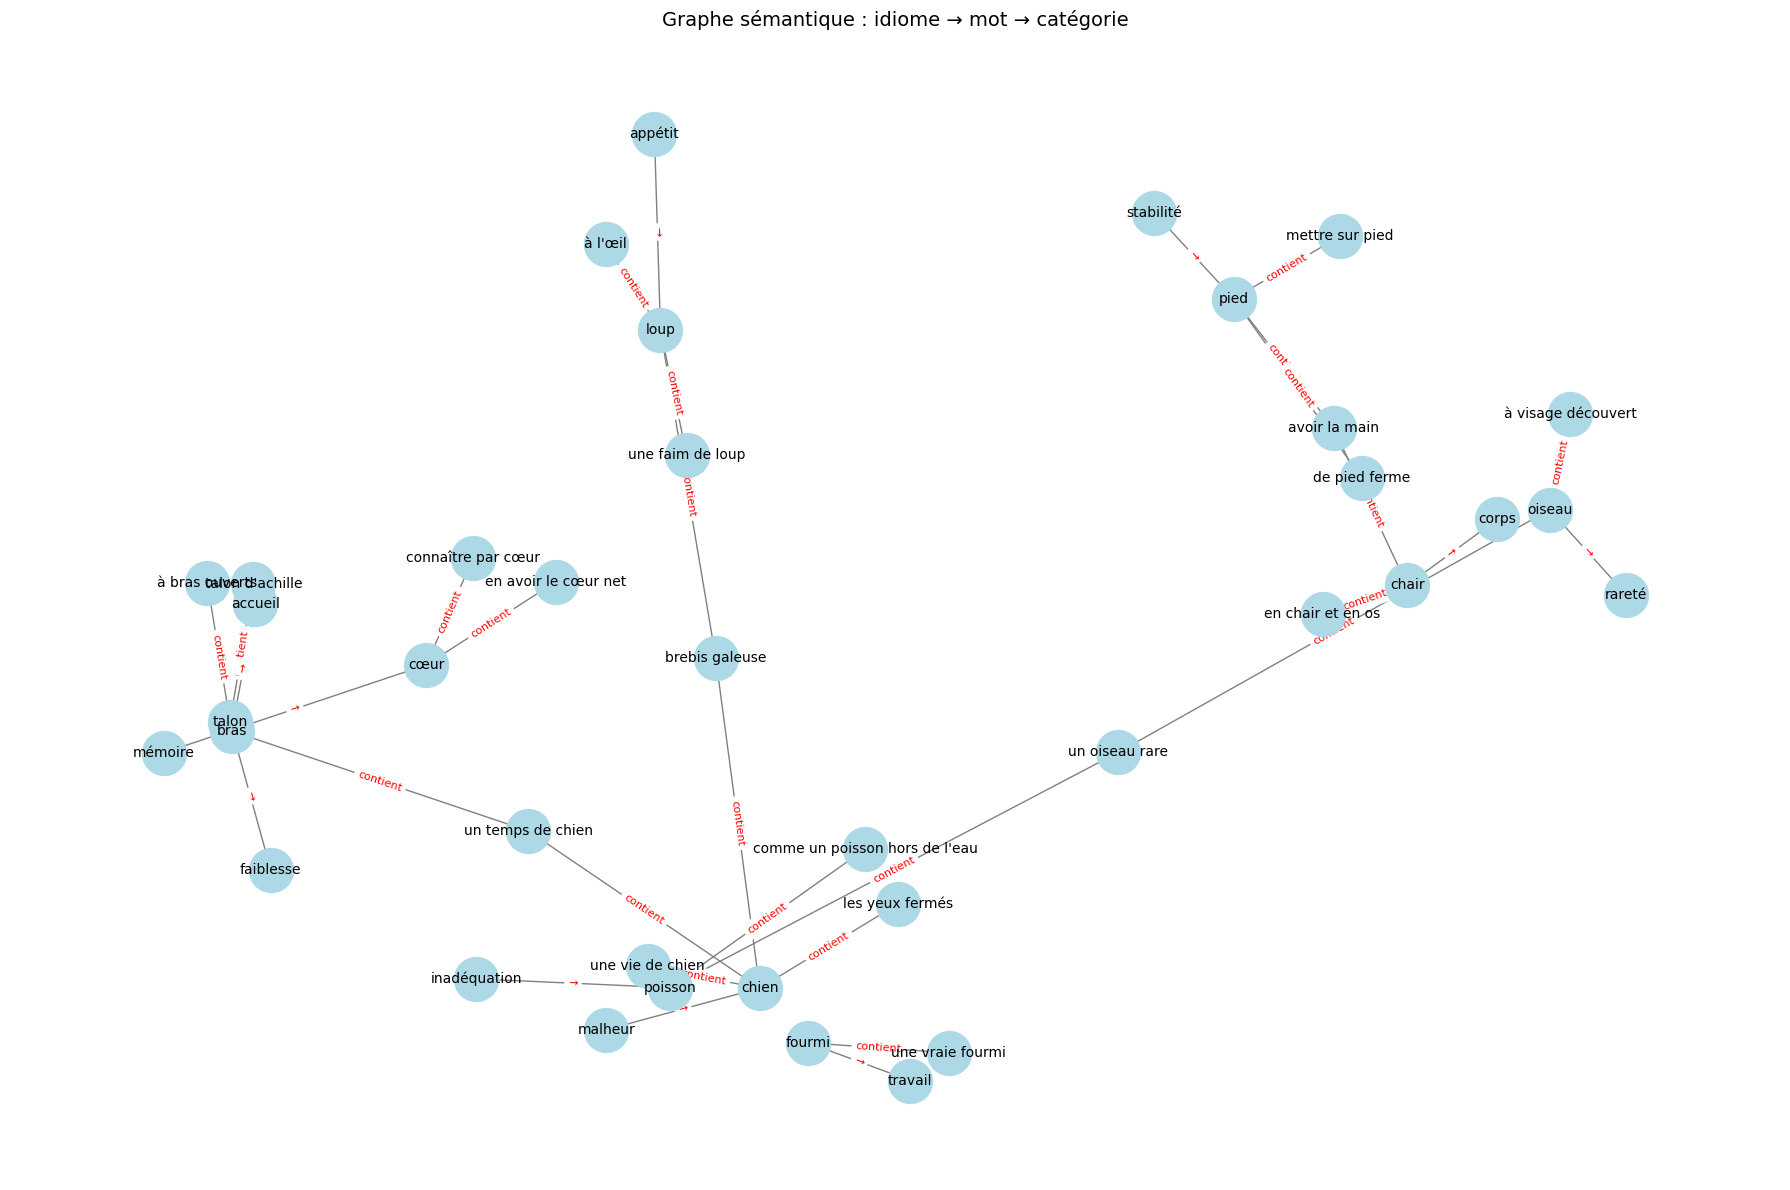

In [ ]:
#完整绘图代码（适用于 CSV 文件包含列 idiome, mot, sémantique）：

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 读取文件（请根据你上传后的路径修改）
df = pd.read_csv("/content/triplets_semantiques.csv")  # 修改为你的文件路径

# 构建有向图
G = nx.DiGraph()

for _, row in df.iterrows():
    idiome = row["idiome"]
    mot = row["mot"]
    sem = row["sémantique"]

    G.add_edge(idiome, mot, label="contient")
    G.add_edge(mot, sem, label="→")

# 可视化
plt.figure(figsize=(18, 12))
pos = nx.spring_layout(G, k=0.6, iterations=100)

nx.draw_networkx_nodes(G, pos, node_size=1000, node_color="lightblue")
nx.draw_networkx_edges(G, pos, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=10)

edge_labels = nx.get_edge_attributes(G, "label")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red", font_size=8)

plt.title("Graphe sémantique : idiome → mot → catégorie", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()


Graphe pondéré 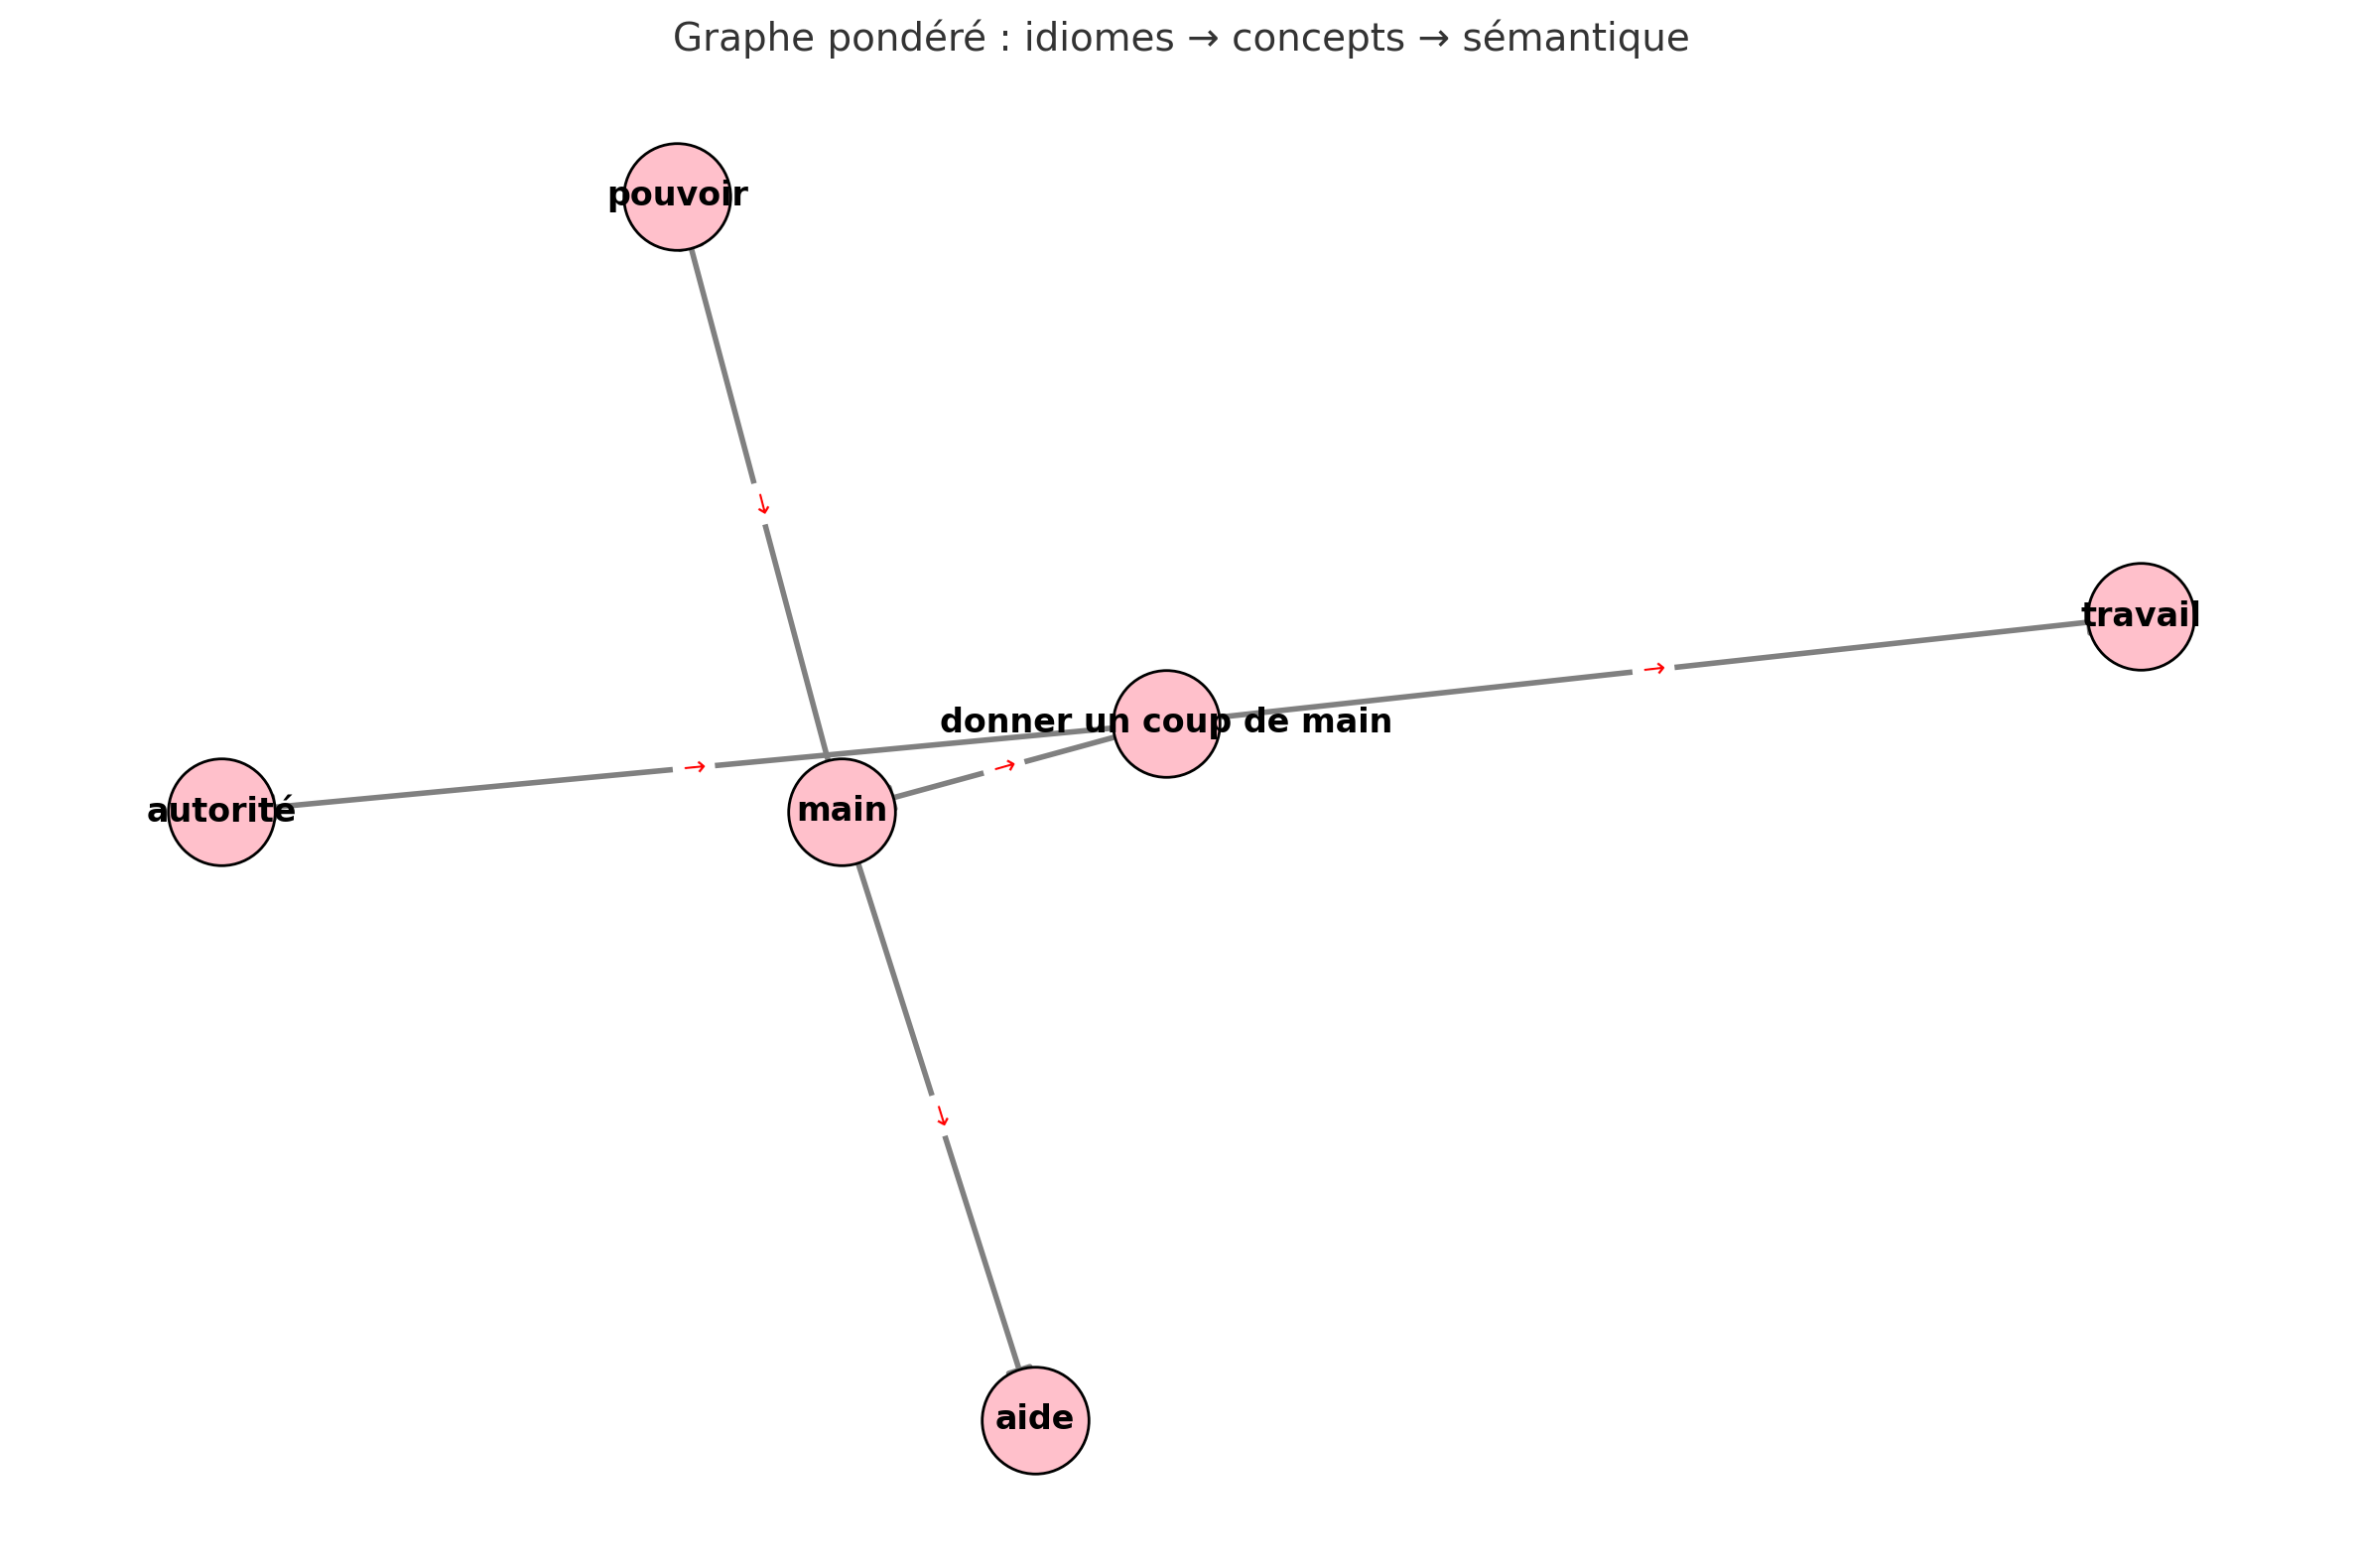

In [ ]:
#1. 载入所有资源

# idiomscopie2.txt 是你的 idiome 列表
with open("idiomscopie2.txt", encoding="utf-8") as f:
    idiomes = [l.strip().lower() for l in f if l.strip()]

# mots clés liés au corps et animaux
with open("mots_corps.txt", encoding="utf-8") as f:
    mots_corps = [l.strip().lower() for l in f if l.strip()]
with open("mots_animaux.txt", encoding="utf-8") as f:
    mots_animaux = [l.strip().lower() for l in f if l.strip()]

mots_cles = set(mots_corps + mots_animaux)


In [ ]:
#2. 提取第一层关系 Idiome → Mot Clé

relations_idiome_mot = []
for idiome in idiomes:
    for mot in mots_cles:
        if mot in idiome:
            relations_idiome_mot.append((idiome, "→", mot))


方法 1：手动或部分自动构建 semantic_map（适合快速起步）

你可以只基于关键词列表建立一个字典，初步标注这些关键词代表的语义范畴。

In [ ]:
#3. 给出这些关键词的语义分类（你可以人工设定，或者用 LLM 自动标注）

# 你可以用映射 dict，后续再自动扩展或让GPT自动标注
semantic_map = {
    "main": "aide",
    "tête": "intelligence",
    "pied": "déplacement",
    "main": "pouvoir",
    "patte": "animal",
    # ...
}


relations_mot_sem = []
for _, _, mot in relations_idiome_mot:
    if mot in semantic_map:
        relations_mot_sem.append((mot, "→", semantic_map[mot]))




In [ ]:
#我的真实语料库


#3. 给出这些关键词的语义分类（你可以人工设定，或者用 LLM 自动标注）

# 你可以用映射 dict，后续再自动扩展或让GPT自动标注
semantic_map = {
    "bras": "accueil",             # à bras ouverts
    "chair": "corps",              # en chair et en os
    "cœur": "mémoire",             # connaître par cœur
    "visage": "identité",          # à visage découvert
    "main": "aide",                # avoir la main, de main de maître, etc.
    "œil": "perception",           # à l'œil, voir à l'œil nu
    "yeux": "confiance",           # les yeux fermés
    "pied": "stabilité",           # de pied ferme, mettre sur pied
    "talon": "faiblesse",          # talon d’Achille
    "tête": "intelligence",        # perdre la tête, tête à tête
    "cochon": "obstination",       # tête de cochon
    "chien": "malheur",            # un temps de chien, une vie de chien
    "poule": "peur",               # poule mouillée
    "fourmi": "travail",           # une vraie fourmi
    "loup": "appétit",             # une faim de loup
    "bouc": "culpabilité",         # bouc émissaire
    "brebis": "déviance",          # brebis galeuse
    "oiseau": "rareté",            # oiseau rare
    "ailes": "autonomie",          # voler de ses propres ailes
    "poisson": "inadéquation",     # comme un poisson hors de l’eau
    "rat": "ruse",                 # être rat, face de rat
}


relations_mot_sem = []
for _, _, mot in relations_idiome_mot:
    if mot in semantic_map:
        relations_mot_sem.append((mot, "→", semantic_map[mot]))




/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22374 (\N{CJK UNIFIED IDEOGRAPH-5766}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35802 (\N{CJK UNIFIED IDEOGRAPH-8BDA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


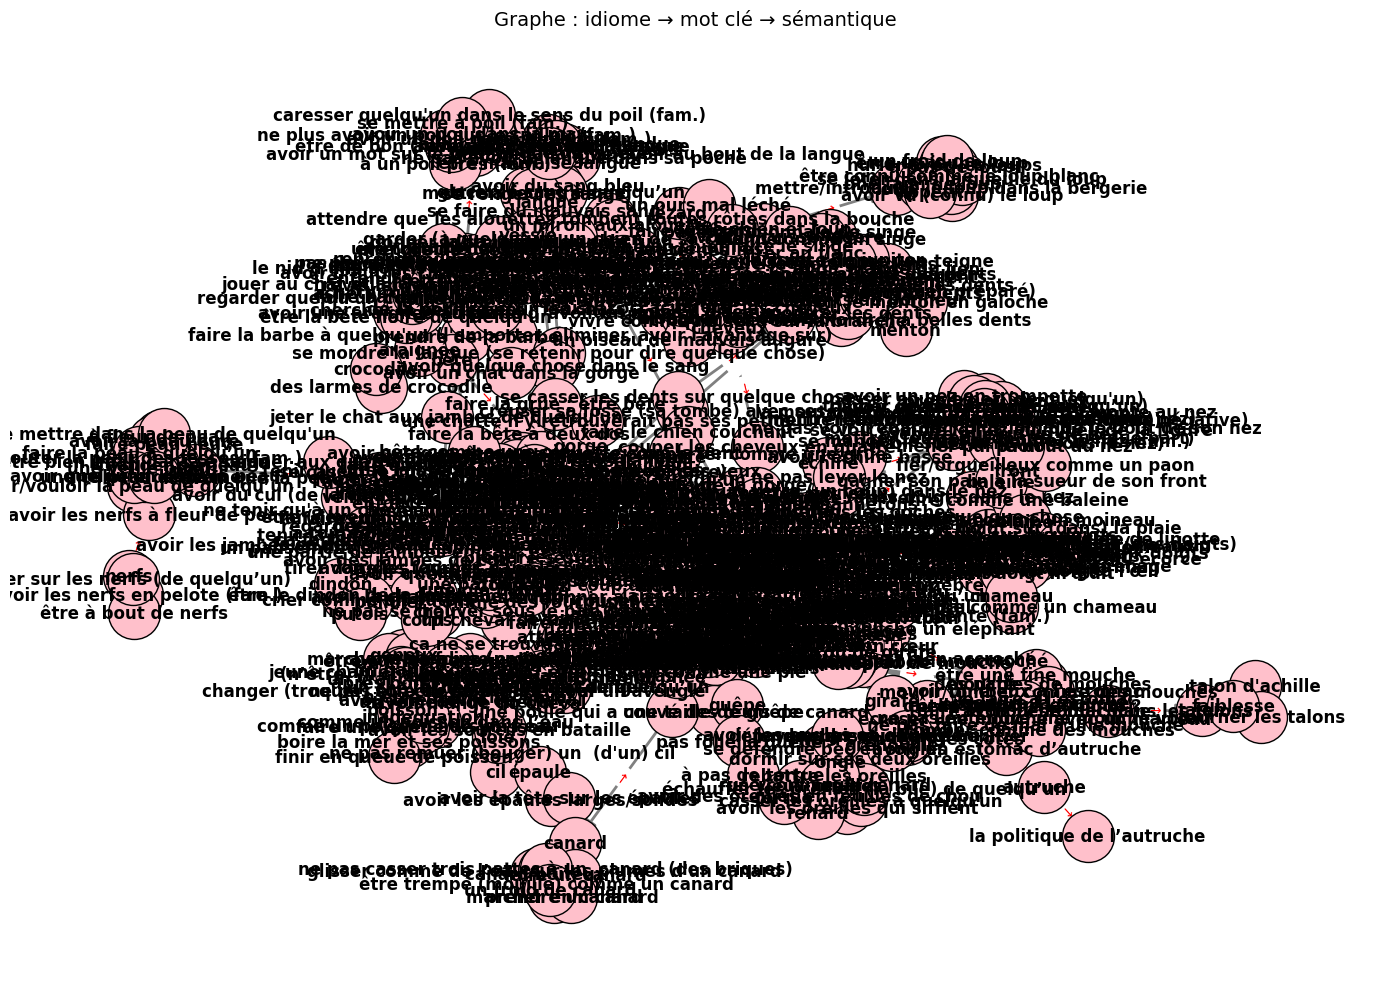

In [ ]:
#4. 合并三元组并可视化

triplets = relations_idiome_mot + relations_mot_sem

import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
for sujet, relation, objet in triplets:
    if G.has_edge(sujet, objet):
        G[sujet][objet]['weight'] += 1
    else:
        G.add_edge(sujet, objet, relation=relation, weight=1)

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.6, seed=42)

nx.draw_networkx_nodes(G, pos, node_color="#FFC0CB", node_size=1400, edgecolors="black")
nx.draw_networkx_edges(G, pos, width=2, edge_color="gray", arrowsize=20)
nx.draw_networkx_labels(G, pos, font_size=12, font_color="black", font_weight="bold")
edge_labels = nx.get_edge_attributes(G, 'relation')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=10)

plt.title("Graphe : idiome → mot clé → sémantique", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
#Bonus：成语 → mot clé 提取代码片段（补充）
import spacy
nlp = spacy.load("fr_core_news_sm")

semantic_map = {}  # 开始为空

# 示例成语列表
idiomes = [
    "à bras ouverts", "en chair et en os", "connaître par cœur", "à visage découvert",
    "avoir la main", "donner un coup de main", "voir à l'œil nu", "perdre la tête",
    "une vie de chien", "une faim de loup", "voler de ses propres ailes"
]

for idiome in idiomes:
    doc = nlp(idiome)
    for token in doc:
        if token.pos_ == "NOUN":
            print(f"{idiome} → {token.text}")



à bras ouverts → bras
en chair et en os → chair
en chair et en os → os
à visage découvert → visage
avoir la main → main
donner un coup de main → coup
donner un coup de main → main
voir à l'œil nu → œil
perdre la tête → tête
une vie de chien → vie
une vie de chien → chien
une faim de loup → faim
voler de ses propres ailes → ailes


In [ ]:
#步骤一：准备你的数据（成语 + fréquence）
import pandas as pd

# 示例：从语料中提取成语及其出现频数
donnees_idiomes = {
    "en chair et en os": 3,
    "connaître par cœur": 1,
    "en avoir le cœur net": 1,
    "à visage découvert": 2,
    "avoir la main": 1,
    "de main de maître": 1,
    "demander la main de": 1,
    "de première main": 14,
    "donner un coup de main": 1,
    "haut la main": 2,
    "à l'œil": 65,
    "les yeux fermés": 15,
    "pour les beaux yeux de": 1,
    "un œil au beurre noir": 1,
    "de pied ferme": 1,
    "mettre sur pied": 20,
    "talon d'Achille": 2,
    "baisser la tête": 1,
    "perdre la tête": 3,
    "un tête à tête": 1,
    "une tête de cochon": 2,
    "faire tourner en bourrique": 1,
    "un temps de chien": 1,
    "une vie de chien": 5,
    "une poule mouillée": 1,
    "une vraie fourmi": 1,
    "une faim de loup": 1,
    "quelle mouche l'a piqué ?": 1,
    "bouc émissaire": 9,
    "brebis galeuse": 1,
    "un oiseau rare": 3,
    "voler de ses propres ailes": 1,
    "comme un poisson hors de l'eau": 1,
    "être rat": 20,
    "face de rat": 1
}


In [ ]:
#步骤二：提取出现次数 ≥ 1 的 idiomes 为列表
idiomes = [idiome for idiome, freq in donnees_idiomes.items() if freq >= 1]
print(idiomes)


['en chair et en os', 'connaître par cœur', 'en avoir le cœur net', 'à visage découvert', 'avoir la main', 'de main de maître', 'demander la main de', 'de première main', 'donner un coup de main', 'haut la main', "à l'œil", 'les yeux fermés', 'pour les beaux yeux de', 'un œil au beurre noir', 'de pied ferme', 'mettre sur pied', "talon d'Achille", 'baisser la tête', 'perdre la tête', 'un tête à tête', 'une tête de cochon', 'faire tourner en bourrique', 'un temps de chien', 'une vie de chien', 'une poule mouillée', 'une vraie fourmi', 'une faim de loup', "quelle mouche l'a piqué ?", 'bouc émissaire', 'brebis galeuse', 'un oiseau rare', 'voler de ses propres ailes', "comme un poisson hors de l'eau", 'être rat', 'face de rat']


In [ ]:
#可选：按频率降序排序

idiomes = sorted(donnees_idiomes.items(), key=lambda x: x[1], reverse=True)
idiomes = [idiome for idiome, freq in idiomes]


#以下为完整代码

In [ ]:
import spacy
import pandas as pd
import json

# 加载 spaCy 法语模型
nlp = spacy.load("fr_core_news_sm")

# 1. 读取你的成语列表
with open("/content/idiomscopie2.txt", "r", encoding="utf-8") as f:
    idioms = [line.strip().lower() for line in f if line.strip()]

# 2. 人工预定义语义映射（词 → 概念）
semantic_map = {
    "bras": "accueil",
    "chair": "corps",
    "cœur": "mémoire",
    "visage": "identité",
    "main": "aide",
    "œil": "perception",
    "yeux": "confiance",
    "pied": "stabilité",
    "talon": "faiblesse",
    "tête": "intelligence",
    "cochon": "obstination",
    "chien": "malheur",
    "poule": "peur",
    "fourmi": "travail",
    "loup": "appétit",
    "bouc": "culpabilité",
    "brebis": "déviance",
    "oiseau": "rareté",
    "ailes": "autonomie",
    "poisson": "inadéquation",
    "rat": "ruse",
    "langue": "parole",
    "nez": "odorat",
    "ventre": "désir",
    "dent": "attaque",
    "griffes": "violence"
}

# 3. 构建三元组 (idiome → mot clé → concept)
triplets = []

for idiome in idioms:
    doc = nlp(idiome)
    for token in doc:
        if token.pos_ == "NOUN":
            mot = token.text.lower()
            if mot in semantic_map:
                concept = semantic_map[mot]
                triplets.append((idiome, mot, concept))

# 4. 保存三元组为 CSV（边）
csv_path = "/content/graph_edges.csv"
with open(csv_path, "w", encoding="utf-8") as f:
    f.write("sujet\trelation\tobjet\tpoids\n") # Changed separator to tab
    for (idiome, mot, concept) in triplets:
        f.write(f"{idiome}\tcontient\t{mot}\t1\n") # Changed separator to tab
        f.write(f"{mot}\texprime\t{concept}\t1\n") # Changed separator to tab

print(f"CSV 已保存：{csv_path}")

# 5. 保存 semantic_map 为 JSON 文件
json_path = "/content/semantic_map2.json"
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(semantic_map, f, ensure_ascii=False, indent=2)

print(f"JSON 已保存：{json_path}")

CSV 已保存：/content/graph_edges.csv
JSON 已保存：/content/semantic_map2.json


#Étape 5 : Visualiser en graphe pondéré


In [ ]:
!pip install networkx pyvis


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.2 MB/s eta 0:00:00


In [ ]:
#Code Python complet pour visualiser :


import pandas as pd
import networkx as nx
from pyvis.network import Network

# 1. Charger les triplets depuis le fichier CSV
csv_path = "/content/graph_edges.csv"  # Chemin de ton CSV
df = pd.read_csv(csv_path, sep='\t') # Added sep='\t'

# 2. Créer un graphe orienté et pondéré
G = nx.DiGraph()

for index, row in df.iterrows():
    sujet = row['sujet']
    relation = row['relation']
    objet = row['objet']
    poids = row['poids']
    G.add_edge(sujet, objet, label=relation, weight=poids)

# 3. Visualiser avec PyVis (graphique interactif dans HTML)
net = Network(height="800px", width="100%", directed=True, notebook=True) # Changed notebook=False to notebook=True

# Ajouter les nœuds et arêtes de G
net.from_nx(G)

# Options de physique (disposition)
net.repulsion(node_distance=200, spring_length=100)

# 4. Exporter le graphe interactif HTML
html_path = "/content/graphe_idiomes.html"
net.show(html_path)
print(f"Graphe interactif sauvegardé : {html_path}")

/content/graphe_idiomes.html
Graphe interactif sauvegardé : /content/graphe_idiomes.html


生成图[texte du lien](https://)


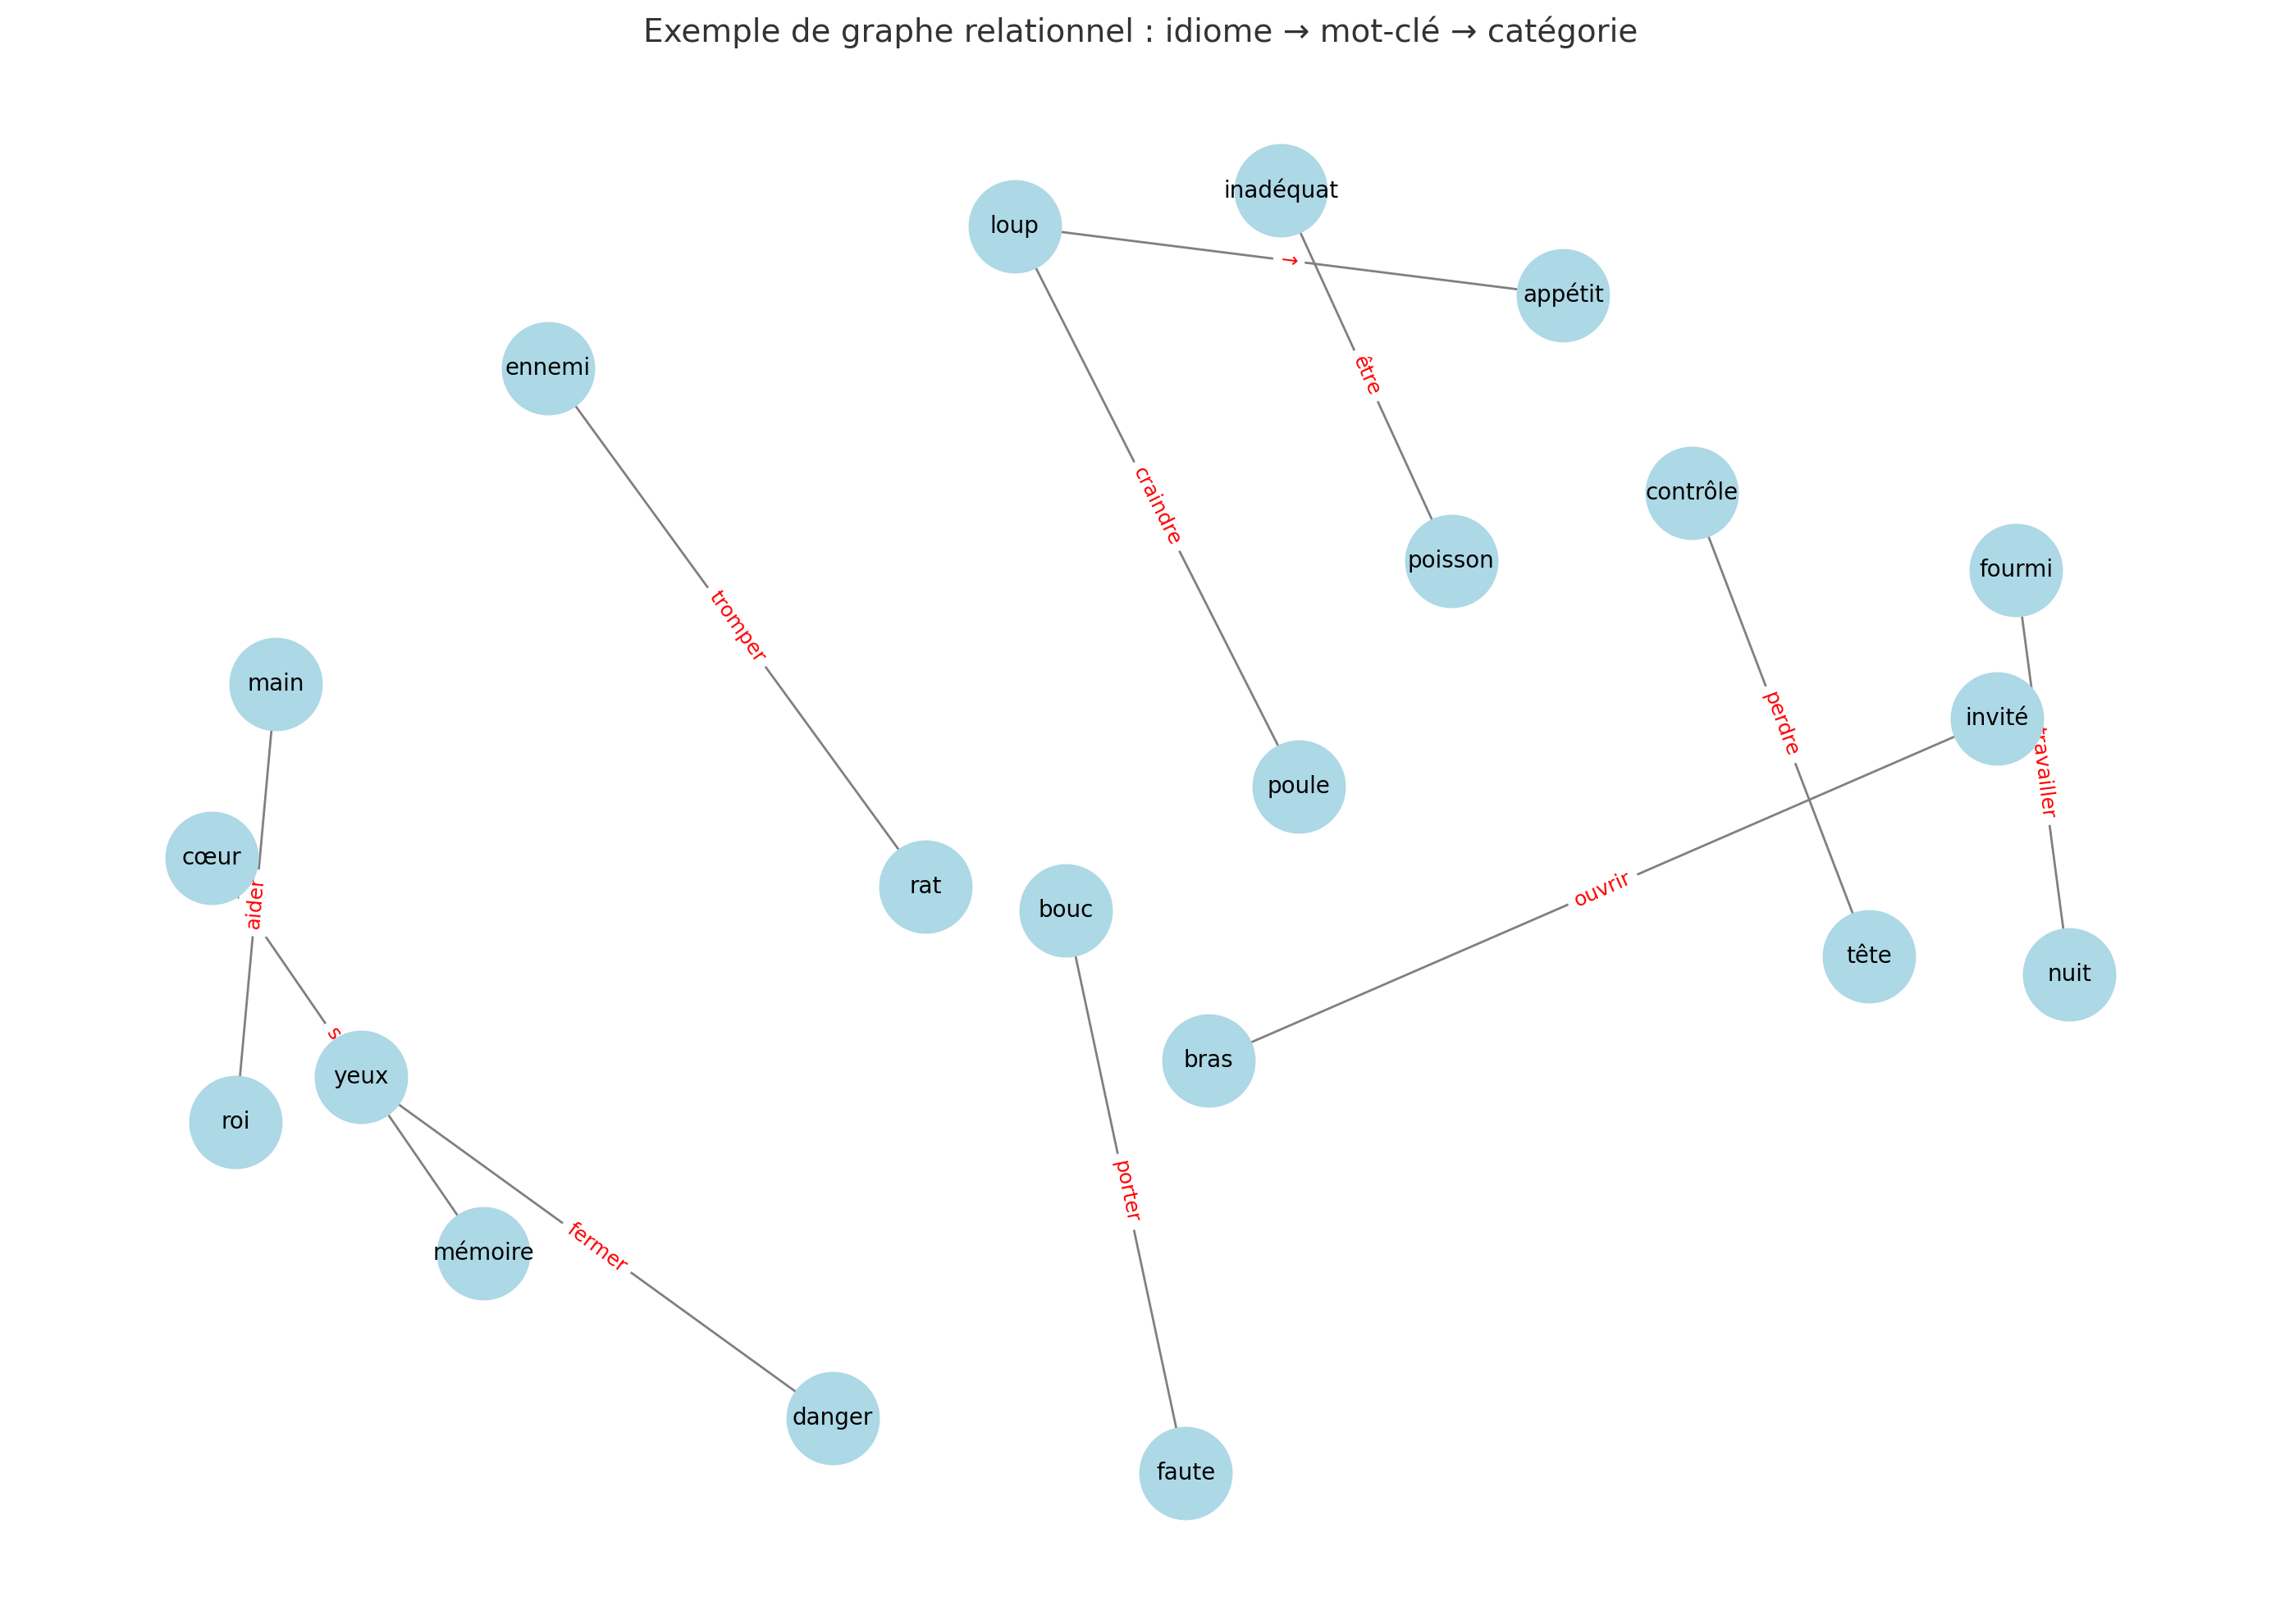

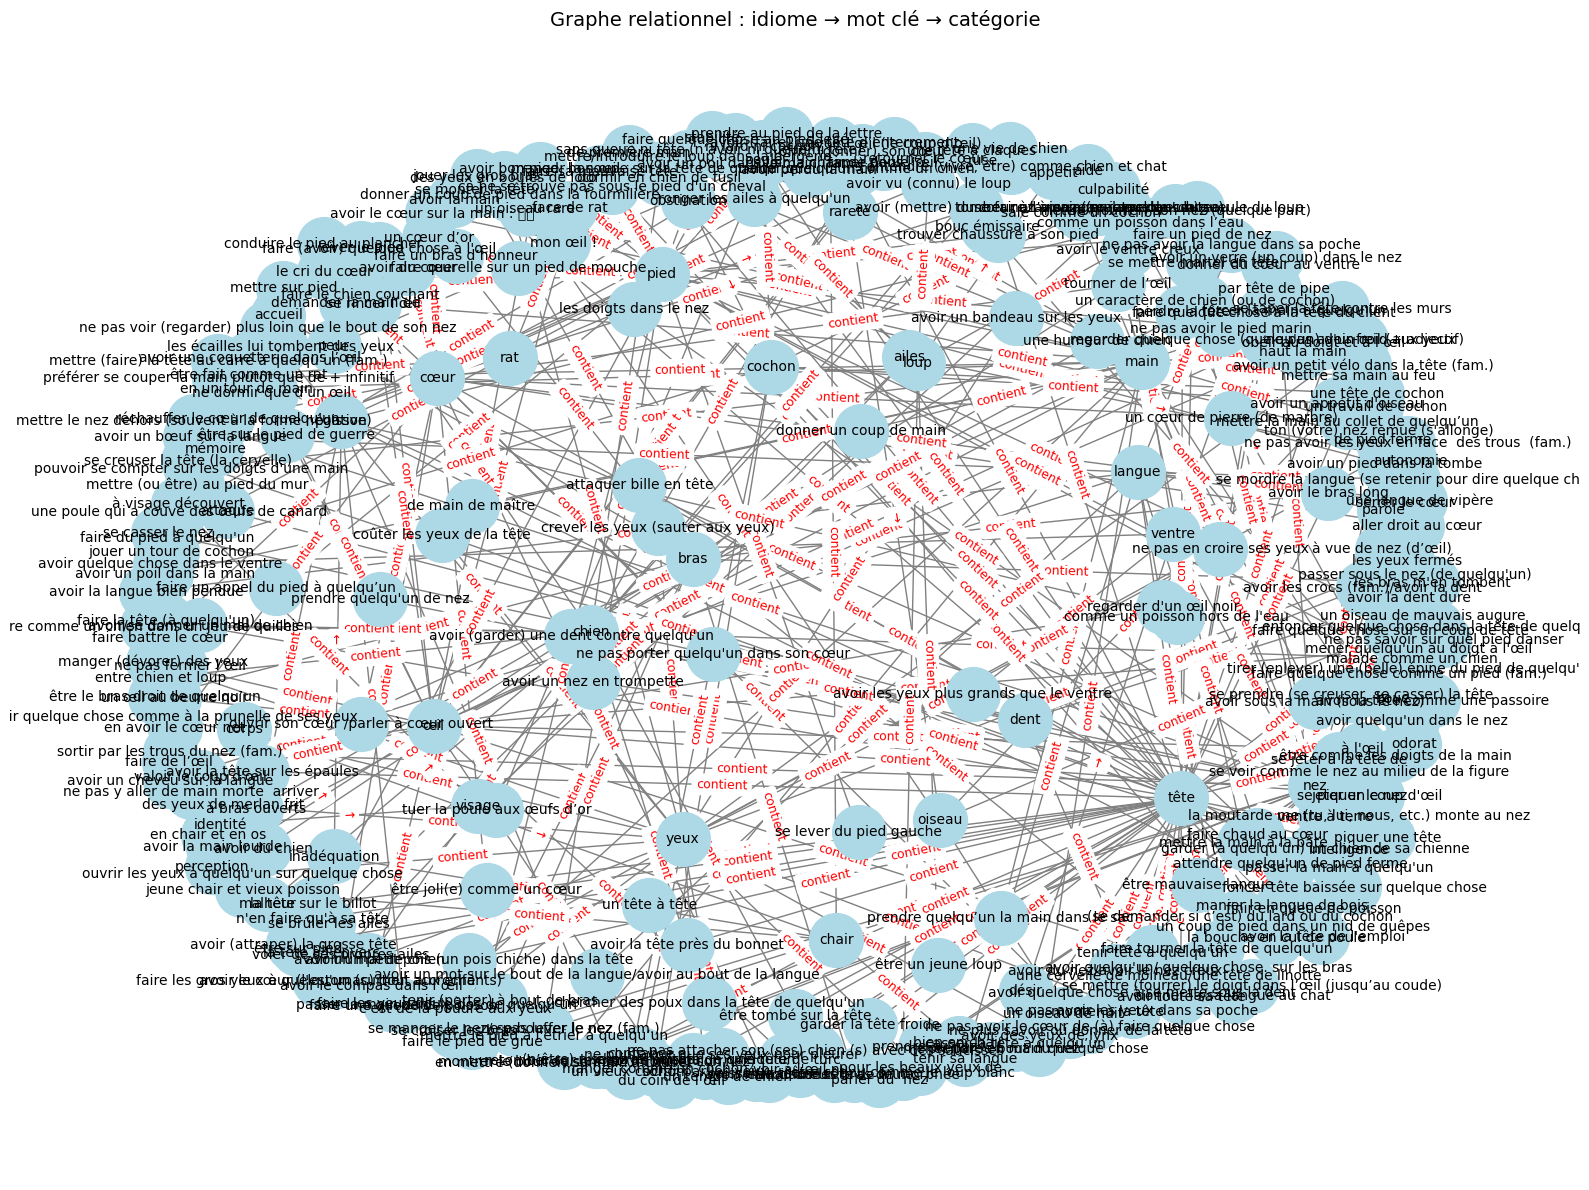

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# 1. Semantic mapping (idiome vers catégorie) - already defined
semantic_map = {
    "bras": "accueil", "chair": "corps", "cœur": "mémoire",
    "visage": "identité", "main": "aide", "œil": "perception",
    "yeux": "confiance", "pied": "stabilité", "talon": "faiblesse",
    "tête": "intelligence", "cochon": "obstination", "chien": "malheur",
    "poule": "peur", "fourmi": "travail", "loup": "appétit", "bouc": "culpabilité",
    "brebis": "déviance", "oiseau": "rareté", "ailes": "autonomie",
    "poisson": "inadéquation", "rat": "ruse"
}

# Assume 'triplets' variable exists from previous steps and contains (idiome, mot, concept) tuples
# Example structure of 'triplets': [('à bras ouverts', 'bras', 'accueil'), ('en chair et en os', 'chair', 'corps'), ...]

# 2. Initialiser le graphe
G = nx.DiGraph()

# 3. Ajouter les triplets idiome → mot clé et mot clé → sémantique
for idiome, mot, sem in triplets:
    # Add edge from idiome to mot clé
    if G.has_edge(idiome, mot):
        G[idiome][mot]['weight'] += 1
    else:
        G.add_edge(idiome, mot, label="contient", weight=1)

    # Add edge from mot clé to sémantique
    if G.has_edge(mot, sem):
         G[mot][sem]['weight'] += 1
    else:
        G.add_edge(mot, sem, label="→", weight=1)


# 4. Visualisation
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, k=0.8)

# Noeuds
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1500)

# Arêtes
nx.draw_networkx_edges(G, pos, arrows=True, edge_color='gray')

# Labels des nœuds
nx.draw_networkx_labels(G, pos, font_size=10)

# Labels des arêtes
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=9)

plt.title("Graphe relationnel : idiome → mot clé → catégorie", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

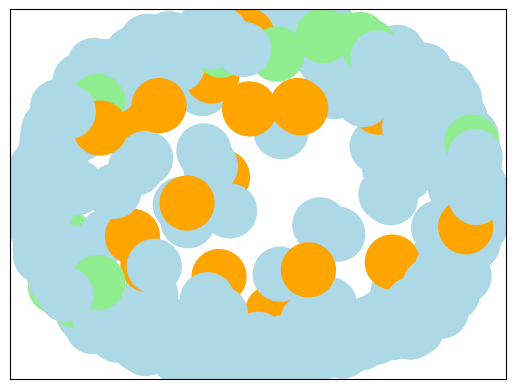

In [ ]:
# 可选：为节点添加类别颜色
node_colors = []
for n in G.nodes:
    if n in semantic_map:
        node_colors.append('orange')  # idiome
    elif n in semantic_map.values():
        node_colors.append('lightgreen')  # catégorie
    else:
        node_colors.append('lightblue')  # mot clé

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1500)


In [ ]:
#如果你希望将这个图保存为高分辨率 PNG / PDF / SVG，只需添加：

plt.savefig("graphe_idiomes.png", dpi=300)


<Figure size 640x480 with 0 Axes>

#Phase 3 – Approches par LLM / Fine-tuning
#Phase 3 – Fine-tuning avec BilBERT

In [ ]:
#Phase 3 – Fine-tuning avec BilBERT



In [ ]:
#把sujet prédicat objet 改为idiome, mot, sémantique

import pandas as pd

# 读取文件（加 sep="\t" 如果是 TSV 文件）
# Read graph_edges.csv with tab separator and correct column names
df = pd.read_csv("/content/graph_edges.csv", sep="\t")

# Rename columns to match the expected names
df = df.rename(columns={"sujet": "idiome", "relation": "mot", "objet": "sémantique"})


# 清洗空值和空白
df = df.dropna(subset=["idiome", "mot", "sémantique"])
df = df[(df["idiome"].str.strip() != "") &
        (df["mot"].str.strip() != "") &
        (df["sémantique"].str.strip() != "")]

# 编码 mot（作为关系）
# The 'mot' column now contains either 'contient' or 'exprime' relations, not the actual keywords.
# Let's encode the 'sémantique' column instead, as that's what the original comment about semantic mapping implies.
relations_uniques = df["sémantique"].unique().tolist()
label2id = {label: i for i, label in enumerate(relations_uniques)}
id2label = {i: label for label, i in label2id.items()}

# 添加编码列
df["label"] = df["sémantique"].map(label2id)

# 查看前几行结果
print(df.head())

                                         idiome       mot sémantique  poids  \
0                                à bras ouverts  contient       bras      1   
1                                          bras   exprime    accueil      1   
2                            avoir le bras long  contient       bras      1   
3                                          bras   exprime    accueil      1   
4  avoir quelqu'un/ quelque chose. sur les bras  contient       bras      1   

   label  
0      0  
1      1  
2      0  
3      1  
4      0  


In [ ]:
#Étape 2 – Train/test split & Dataset HuggingFace


from sklearn.model_selection import train_test_split
from datasets import Dataset

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)


In [ ]:
# Étape 3 – Tokenization

from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

def tokenize(batch):
    return tokenizer(
        [s + " [SEP] " + o for s, o in zip(batch["idiome"], batch["sémantique"])],
        padding="max_length",
        truncation=True,
        max_length=128
    )

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)


Map:   0%|          | 0/473 [00:00<?, ? examples/s]

Map:   0%|          | 0/119 [00:00<?, ? examples/s]

In [ ]:
from datasets import Dataset
from transformers import BertTokenizer

# Charger tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

# 转换为 Dataset 格式
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenization
def tokenize(batch):
    return tokenizer(
        [s + " [SEP] " + o for s, o in zip(batch["idiome"], batch["sémantique"])],
        padding="max_length",
        truncation=True,
        max_length=128
    )

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)


Map:   0%|          | 0/473 [00:00<?, ? examples/s]

Map:   0%|          | 0/119 [00:00<?, ? examples/s]

In [ ]:
#Étape 4 – Chargement du modèle BilBERT ou mBERT

from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#看不到进度条

#Étape 5 – Entraînement avec Trainer

from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = predictions.argmax(axis=1)
    return {"accuracy": accuracy_score(labels, preds)}

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch", # Changed from evaluation_strategy
    save_strategy="epoch", # Changed from save_strategy
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none" # Explicitly disable all reporting integrations
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"  # 禁用 wandb，避免 API key 提示

from transformers import Trainer, TrainerCallback
from tqdm.auto import tqdm
import sys

class TqdmProgressCallback(TrainerCallback):
    def __init__(self, total_epochs):
        self.epoch_bar = tqdm(total=total_epochs, desc="Entraînement des époques")

    def on_epoch_end(self, args, state, control, **kwargs):
        self.epoch_bar.update(1)
        if state.log_history and "loss" in state.log_history[-1]:
            self.epoch_bar.set_postfix({"loss": f"{state.log_history[-1]['loss']:.4f}"})
        sys.stdout.flush()

    def on_train_end(self, args, state, control, **kwargs):
        self.epoch_bar.close()
        print(" Entraînement terminé.")

#  Trainer：明确指定 callback，只使用我们自定义的进度条
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[TqdmProgressCallback(training_args.num_train_epochs)]
)

trainer.train()


Entraînement des époques:   0%|          | 0/4 [00:00<?, ?it/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


RuntimeError: WandbCallback requires wandb to be installed. Run `pip install wandb`.

In [ ]:
#Étape 6 – Évaluation du modèle entraîné

# Prédictions
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(axis=1)
y_true = predictions.label_ids

# Affichage
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print(classification_report(
    y_true,
    y_pred,
    target_names=[id2label[i] for i in sorted(set(y_true))]
))

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True,
            xticklabels=[id2label[i] for i in sorted(set(y_true))],
            yticklabels=[id2label[i] for i in sorted(set(y_true))],
            cmap="Blues", fmt="d")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Error: You must call wandb.init() before wandb.log()

其他办法完整版 - 必须切换到CPU格式

In [ ]:
!pip install -U transformers


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"  # 关闭 wandb
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # 若调试 GPU 报错，取消注释

import pandas as pd
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from datasets import Value

# 1. 加载 CSV 文件
csv_path = "/content/triplets_semantiques.csv"
df = pd.read_csv(csv_path)

# 2. 数据清洗：去除空值和空字符串
df = df.dropna(subset=["idiome", "mot", "sémantique"])
df = df[(df["idiome"].str.strip() != "") & (df["mot"].str.strip() != "") & (df["sémantique"].str.strip() != "")]

# 3. 标签编码
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["sémantique"])

# 检查标签合法性
num_labels = len(label_encoder.classes_)
invalid_labels = df[~df["label"].between(0, num_labels - 1)]
if not invalid_labels.empty:
    print("有非法标签，已删除以下行：")
    print(invalid_labels)
    df = df[df["label"].between(0, num_labels - 1)]

# 保存映射
label2id = {label: i for i, label in enumerate(label_encoder.classes_)}
id2label = {i: label for label, i in label2id.items()}

# 4. 分割数据集
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df.reset_index(drop=True))

# 5. 加载 tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

# 6. Tokenization 函数
def preprocess_function(examples):
    texts = [f"{i} [SEP] {k} [SEP] {s}" for i, k, s in zip(examples['idiome'], examples['mot'], examples['sémantique'])]
    tokenized = tokenizer(texts, padding="max_length", truncation=True, max_length=128)
    tokenized["label"] = [int(l) for l in examples["label"]]
    return tokenized

# 7. 应用 tokenization
train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)

# 8. 显式设置 label 类型为 int64
train_dataset = train_dataset.cast_column("label", Value("int64"))
val_dataset = val_dataset.cast_column("label", Value("int64"))

"""
# 9. 加载模型
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)
"""


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Map:   0%|          | 0/17 [00:00<?, ? examples/s]

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/17 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/5 [00:00<?, ? examples/s]

'\n# 9. 加载模型\nmodel = BertForSequenceClassification.from_pretrained(\n    "bert-base-multilingual-cased",\n    num_labels=num_labels,\n    id2label=id2label,\n    label2id=label2id\n)\n'

In [ ]:
import torch

# 强制 PyTorch 只使用 CPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# 显式设置 device 为 CPU
device = torch.device("cpu")

# 把模型加载到 CPU
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
).to(device)  # ⬅ 关键点：加上 .to(device)


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 10. 设置训练参数（你也可以添加 no_cuda=True 来在 CPU 上跑）
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch", # Corrected parameter name
    save_strategy="epoch", # Corrected parameter name
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=4,
    weight_decay=0.01,
    report_to="none"
)

In [ ]:

# 11. 计算评估指标
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    return {"accuracy": accuracy_score(labels, preds)}


In [ ]:
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["sémantique"])

print("所有标签（classes_）:", label_encoder.classes_)
print("最大标签数:", len(label_encoder.classes_))
print("实际数据中最大 label 值:", df["label"].max())
print("最小 label 值:", df["label"].min())


所有标签（classes_）: ['accueil' 'appétit' 'corps' 'faiblesse' 'inadéquation' 'malheur'
 'mémoire' 'rareté' 'stabilité' 'travail']
最大标签数: 10
实际数据中最大 label 值: 9
最小 label 值: 0


In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=len(label_encoder.classes_),  # 确保是整数，如 8、10 等
    id2label=id2label,
    label2id=label2id
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from datasets import ClassLabel

train_dataset = train_dataset.cast_column("label", Value("int64"))
val_dataset = val_dataset.cast_column("label", Value("int64"))


Casting the dataset:   0%|          | 0/17 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/5 [00:00<?, ? examples/s]

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    no_cuda=True  # 强制使用 CPU
)





/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1604: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()


TrainOutput(global_step=8, training_loss=2.09529185295105, metrics={'train_runtime': 159.496, 'train_samples_per_second': 0.426, 'train_steps_per_second': 0.05, 'total_flos': 4473209223168.0, 'train_loss': 2.09529185295105, 'epoch': 4.0})

In [ ]:
#Étape 6 – Évaluation du modèle entraîné

# Prédictions
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(axis=1)
y_true = predictions.label_ids

# Affichage
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print(classification_report(
    y_true,
    y_pred,
    target_names=[id2label[i] for i in sorted(set(y_true))]
))

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True,
            xticklabels=[id2label[i] for i in sorted(set(y_true))],
            yticklabels=[id2label[i] for i in sorted(set(y_true))],
            cmap="Blues", fmt="d")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


NameError: name 'test_dataset' is not defined

In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=8c0494d257fb2cbb999e0497ea7d30a32449b3ef937f8753594ff3497d29497e
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
# 方法 1：使用 Hugging Face 的 evaluate 库


!pip install evaluate

import evaluate

# 加载常用指标
bleu = evaluate.load("bleu")
meteor = evaluate.load("meteor")
rouge = evaluate.load("rouge")

# 假设你有这些数据
predictions = ["main is power", "main represents authority"]
references = [["main is a symbol of power"], ["main signifies authority"]]

# 分别评估
print("BLEU:", bleu.compute(predictions=predictions, references=references))
print("METEOR:", meteor.compute(predictions=predictions, references=references))
print("ROUGE:", rouge.compute(predictions=predictions, references=references))


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


BLEU: {'bleu': 0.0, 'precisions': [0.8333333333333334, 0.25, 0.0, 0.0], 'brevity_penalty': 0.6065306597126334, 'length_ratio': 0.6666666666666666, 'translation_length': 6, 'reference_length': 9}
METEOR: {'meteor': np.float64(0.3908382066276803)}
ROUGE: {'rouge1': np.float64(0.6666666666666666), 'rouge2': np.float64(0.14285714285714288), 'rougeL': np.float64(0.6666666666666666), 'rougeLsum': np.float64(0.6666666666666666)}


In [ ]:
#方法 2：使用 BERTScore（句子级语义相似度）

!pip install bert-score

from bert_score import score

preds = ["main is power", "main represents authority"]
refs = ["main is a symbol of power", "main signifies authority"]

P, R, F1 = score(preds, refs, lang="en")
print(f"BERTScore F1: {F1.mean().item():.4f}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 793.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 563.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 26.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore F1: 0.9443


#Phase 5 – Ontologie et interface finale

#phrase 6 lexicographique

In [ ]:
!pip install rdflib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.1/565.1 kB 8.5 MB/s eta 0:00:00


In [ ]:
from rdflib import Graph, Namespace, URIRef, Literal, RDF

g = Graph()
EX = Namespace("http://example.org/onto#")
g.bind("ex", EX)

# Exemple pour une expression idiomatique
idiome = URIRef(EX["donner_un_coup_de_main"])
mot_cle = URIRef(EX["aider"])
relation = EX["exprime"]

g.add((idiome, RDF.type, EX.MultiWordExpression))
g.add((idiome, relation, mot_cle))
g.serialize("idiomes.owl", format="xml")


<Graph identifier=N0f690950af98426e9a9619bd98bff11f (<class 'rdflib.graph.Graph'>)>

另一个办法

In [ ]:
from rdflib import Graph, Namespace, Literal, RDF, URIRef
from rdflib.namespace import SKOS, OWL, RDFS

# Initialisation
g = Graph()
ONTOL = Namespace("http://example.org/ontolex#")
g.bind("ontolex", ONTOL)
g.bind("skos", SKOS)

# Exemple : "donner un coup de main" → "帮忙"
idiome_fr = URIRef("http://example.org/expr/donner_un_coup_de_main")
form_fr = URIRef(idiome_fr + "/form")
sense_fr = URIRef(idiome_fr + "/sense")
concept = URIRef("http://example.org/concept/AideSpontanée")

# Définition française
g.add((idiome_fr, RDF.type, ONTOL.MultiWordExpression))
g.add((idiome_fr, ONTOL.canonicalForm, form_fr))
g.add((form_fr, ONTOL.writtenRep, Literal("donner un coup de main", lang="fr")))
g.add((idiome_fr, ONTOL.sense, sense_fr))
g.add((sense_fr, ONTOL.reference, concept))

# Définition chinoise
idiome_zh = URIRef("http://example.org/expr/bangmang")
form_zh = URIRef(idiome_zh + "/form")
sense_zh = URIRef(idiome_zh + "/sense")

g.add((idiome_zh, RDF.type, ONTOL.LexicalEntry))
g.add((idiome_zh, ONTOL.canonicalForm, form_zh))
g.add((form_zh, ONTOL.writtenRep, Literal("帮忙", lang="zh")))
g.add((idiome_zh, ONTOL.sense, sense_zh))
g.add((sense_zh, ONTOL.reference, concept))

# Traduction
VARTRANS = Namespace("http://www.w3.org/ns/lemon/vartrans#")
g.bind("vartrans", VARTRANS)
trans = URIRef("http://example.org/translation/1")
g.add((trans, RDF.type, VARTRANS.Translation))
g.add((trans, VARTRANS.source, sense_fr))
g.add((trans, VARTRANS.target, sense_zh))

# Sauvegarde
g.serialize("idiomes_ontolex.owl", format="xml")


<Graph identifier=N76f1a611c6cf464fb546e7c575e34885 (<class 'rdflib.graph.Graph'>)>

In [ ]:
from rdflib import Graph, Namespace, Literal, RDF, URIRef
from rdflib.namespace import SKOS, RDFS

# Namespaces
ONTOLEX = Namespace("http://www.w3.org/ns/lemon/ontolex#")
VARTRANS = Namespace("http://www.w3.org/ns/lemon/vartrans#")
LEXINFO = Namespace("http://www.lexinfo.net/ontology/3.0/lexinfo#")
EX = Namespace("http://example.org/idioms#")

# Initialiser le graphe
g = Graph()
g.bind("rdf", RDF)
g.bind("rdfs", RDFS)
g.bind("skos", SKOS)
g.bind("ontolex", ONTOLEX)
g.bind("vartrans", VARTRANS)
g.bind("lexinfo", LEXINFO)
g.bind("", EX)

# ---------- Concepts ----------
concepts = {
    "CorpsHumain": [],
    "Coeur": ["CorpsHumain"],
    "Animaux": [],
    "Bouc": ["Animaux"],
    "Poisson": ["Animaux"]
}

for concept, parents in concepts.items():
    concept_uri = EX[concept]
    g.add((concept_uri, RDF.type, SKOS.Concept))
    g.add((concept_uri, RDFS.label, Literal(concept.replace("_", " "), lang="fr")))
    for parent in parents:
        g.add((concept_uri, SKOS.broader, EX[parent]))

# ---------- Fonction : ajouter un idiome ----------
def ajouter_idiome(uri_base, forme, langue, concept_uri, commentaire=None, prononciation=None):
    idiome_uri = EX[uri_base]
    form_node = URIRef(idiome_uri + "/form")
    sense_node = URIRef(idiome_uri + "/sense")

    g.add((idiome_uri, RDF.type, ONTOLEX.LexicalEntry))
    g.add((idiome_uri, ONTOLEX.canonicalForm, form_node))
    g.add((form_node, ONTOLEX.writtenRep, Literal(forme, lang=langue)))
    if prononciation:
        g.add((form_node, ONTOLEX.pronunciation, Literal(prononciation, lang=langue)))
    g.add((idiome_uri, ONTOLEX.sense, sense_node))
    g.add((sense_node, RDF.type, ONTOLEX.LexicalSense))
    g.add((sense_node, ONTOLEX.concept, concept_uri))
    if commentaire:
        g.add((sense_node, RDFS.comment, Literal(commentaire, lang="fr")))
    return sense_node

# ---------- Ajout des idiomes ----------
# 1. connaître par cœur / 熟记于心
s1 = ajouter_idiome("connaitre_par_coeur", "connaître par cœur", "fr", EX["Coeur"],
                    "En l'absence de journaux, certains prospecteurs lisaient les étiquettes des conserves jusqu'à les connaître par cœur.")
s2 = ajouter_idiome("熟记于心", "熟记于心", "zh", EX["Coeur"], prononciation="Shú jì yú xīn")
g.add((EX["trad_connaitre_par_coeur"], RDF.type, VARTRANS.Translation))
g.add((EX["trad_connaitre_par_coeur"], VARTRANS.source, s1))
g.add((EX["trad_connaitre_par_coeur"], VARTRANS.target, s2))

# 2. bouc émissaire / 替罪羊
s3 = ajouter_idiome("bouc_emissaire", "bouc émissaire", "fr", EX["Bouc"],
                    "Hallstein devint le bouc émissaire de la crise.")
s4 = ajouter_idiome("替罪羊", "替罪羊", "zh", EX["Bouc"], prononciation="tì zuì yáng")
g.add((EX["trad_bouc_emissaire"], RDF.type, VARTRANS.Translation))
g.add((EX["trad_bouc_emissaire"], VARTRANS.source, s3))
g.add((EX["trad_bouc_emissaire"], VARTRANS.target, s4))

# 3. comme un poisson hors de l'eau / 如鱼得水
s5 = ajouter_idiome("comme_un_poisson_hors_de_l_eau", "comme un poisson hors de l'eau", "fr", EX["Poisson"],
                    "Il est également le scénariste de 'Comme un poisson hors de l'eau' (1999).")
s6 = ajouter_idiome("如鱼得水", "如鱼得水", "zh", EX["Poisson"], prononciation="rú yú dé shuǐ")
g.add((EX["trad_poisson"], RDF.type, VARTRANS.Translation))
g.add((EX["trad_poisson"], VARTRANS.source, s5))
g.add((EX["trad_poisson"], VARTRANS.target, s6))

# ---------- Sauvegarde ----------
g.serialize("idiomes_ontolex.owl", format="pretty-xml")
print(" Fichier idiomes_ontolex.owl généré avec succès.")


 Fichier idiomes_ontolex.owl généré avec succès.


In [ ]:
from rdflib import Graph, Namespace, Literal, RDF, URIRef
from rdflib.namespace import SKOS, RDFS

# Namespaces
ONTOLEX = Namespace("http://www.w3.org/ns/lemon/ontolex#")
VARTRANS = Namespace("http://www.w3.org/ns/lemon/vartrans#")
LEXINFO = Namespace("http://www.lexinfo.net/ontology/3.0/lexinfo#")
EX = Namespace("http://example.org/idioms#")

# Initialiser le graphe
g = Graph()
g.bind("rdf", RDF)
g.bind("rdfs", RDFS)
g.bind("skos", SKOS)
g.bind("ontolex", ONTOLEX)
g.bind("vartrans", VARTRANS)
g.bind("lexinfo", LEXINFO)
g.bind("", EX)

# ---------- Concepts ----------
concepts = {
    "CorpsHumain": [],
    "Coeur": ["CorpsHumain"],
    "Animaux": [],
    "Bouc": ["Animaux"],
    "Poisson": ["Animaux"]
}

for concept, parents in concepts.items():
    concept_uri = EX[concept]
    g.add((concept_uri, RDF.type, SKOS.Concept))
    g.add((concept_uri, RDFS.label, Literal(concept.replace("_", " "), lang="fr")))
    for parent in parents:
        g.add((concept_uri, SKOS.broader, EX[parent]))

# ---------- Fonction : ajouter un idiome ----------
def ajouter_idiome(uri_base, forme, langue, concept_uri, commentaire=None, prononciation=None):
    idiome_uri = EX[uri_base]
    form_node = URIRef(idiome_uri + "/form")
    sense_uri = EX[f"sense_{uri_base}"]

    g.add((idiome_uri, RDF.type, ONTOLEX.LexicalEntry))
    # Ajouter le type MultiWordExpression pour les idiomes en français
    if langue == "fr":
        g.add((idiome_uri, RDF.type, ONTOLEX.MultiWordExpression))

    g.add((idiome_uri, ONTOLEX.canonicalForm, form_node))
    g.add((form_node, ONTOLEX.writtenRep, Literal(forme, lang=langue)))
    if prononciation:
        g.add((form_node, ONTOLEX.pronunciation, Literal(prononciation, lang=langue)))
    g.add((idiome_uri, ONTOLEX.sense, sense_uri))
    g.add((sense_uri, RDF.type, ONTOLEX.LexicalSense))
    g.add((sense_uri, ONTOLEX.concept, concept_uri))
    if commentaire:
        g.add((sense_uri, RDFS.comment, Literal(commentaire, lang="fr")))
    return sense_uri

# ---------- Ajout des idiomes + traductions ----------

# 1. connaître par cœur / 熟记于心
s1 = ajouter_idiome("connaitre_par_coeur", "connaître par cœur", "fr", EX["Coeur"],
                    "En l'absence de journaux, certains prospecteurs lisaient les étiquettes des conserves jusqu'à les connaître par cœur.")
s2 = ajouter_idiome("熟记于心", "熟记于心", "zh", EX["Coeur"], prononciation="Shú jì yú xīn")
g.add((EX["trad_connaitre_par_coeur"], RDF.type, VARTRANS.Translation))
g.add((EX["trad_connaitre_par_coeur"], VARTRANS.source, s1))
g.add((EX["trad_connaitre_par_coeur"], VARTRANS.target, s2))

# 2. bouc émissaire / 替罪羊
s3 = ajouter_idiome("bouc_emissaire", "bouc émissaire", "fr", EX["Bouc"],
                    "Hallstein devint le bouc émissaire de la crise.")
s4 = ajouter_idiome("替罪羊", "替罪羊", "zh", EX["Bouc"], prononciation="tì zuì yáng")
g.add((EX["trad_bouc_emissaire"], RDF.type, VARTRANS.Translation))
g.add((EX["trad_bouc_emissaire"], VARTRANS.source, s3))
g.add((EX["trad_bouc_emissaire"], VARTRANS.target, s4))

# 3. comme un poisson hors de l'eau / 如鱼得水
s5 = ajouter_idiome("comme_un_poisson_hors_de_l_eau", "comme un poisson hors de l'eau", "fr", EX["Poisson"],
                    "Il est également le scénariste de 'Comme un poisson hors de l'eau' (1999).")
s6 = ajouter_idiome("如鱼得水", "如鱼得水", "zh", EX["Poisson"], prononciation="rú yú dé shuǐ")
g.add((EX["trad_poisson"], RDF.type, VARTRANS.Translation))
g.add((EX["trad_poisson"], VARTRANS.source, s5))
g.add((EX["trad_poisson"], VARTRANS.target, s6))

# ---------- Sauvegarde ----------
g.serialize("idiomes_ontolex2.owl", format="pretty-xml")
print("Fichier idiomes_ontolex2.owl généré avec succès.")


Fichier idiomes_ontolex2.owl généré avec succès.
